In [48]:
import numpy as np
import pandas as pd
import seaborn as sns

import matplotlib.pyplot as plt

In [167]:
# Read hyperopt data
df = pd.read_csv("../results/hyperopt.csv")

# Baseline
df_baseline = pd.read_csv("../results/data.csv")
df_baseline["adapter"] = df_baseline["adapter"].fillna("no_adapter")

In [175]:
forecasting_horizon = 24
dataset_name = "Illness" + f"_pred={forecasting_horizon}"
model_name = "AutonLab/MOMENT-1-small"
adapter = "flow"
n_components = 7
hypers = [
    "hidden_dim",
    "learning_rate",
    "batch_size",
    "num_coupling",
]

df_sub = df[
    (df["dataset"] == dataset_name)
    & (df["model"] == model_name)
    & (df["adapter"] == adapter)
    & (df["n_components"] == n_components)
]
df_baseline_sub = df_baseline[
    (df_baseline["dataset"] == dataset_name.split("_")[0])
    & (df_baseline["foundational_model"] == model_name)
    & (df_baseline["is_fine_tuned"].isin(["False"]))
    & (df_baseline["adapter"] == "no_adapter")
]

In [176]:
df_clean = df_sub.drop(
    columns=[
        "dataset",
        "model",
        "adapter",
        "n_features",
        "forecasting_horizon",
        "n_components",
        "context_length",
    ],
    inplace=False,
)
df_baseline_clean = df_baseline_sub.drop(
    columns=[
        "dataset",
        "foundational_model",
        "adapter",
        "n_features",
        "forecasting_horizon",
        "n_components",
        "context_length",
        "is_fine_tuned",
    ],
    inplace=False,
)
df_clean = df_clean.loc[:, df_clean.nunique() != 1]
df_clean = df_clean.dropna(axis=1, how="all")
df_clean = df_clean.dropna()

In [177]:
df_clean.head(5)

,hidden_dim,learning_rate,batch_size,running_time,seed,mse,mae,test_mse,test_mae,num_coupling
2020,64,0.001,64,44.558505,21263,1.082734,0.786742,5.515307,1.621932,2.0
2021,128,0.001,32,28.233110,21263,0.915197,0.742735,5.011490,1.517220,1.0
2022,64,0.010,64,37.199934,21263,1.372470,0.922138,5.441062,1.720464,2.0
2023,128,0.010,32,52.085460,21263,1.102127,0.826419,4.577266,1.516261,1.0
2024,128,0.001,64,35.952252,21263,0.956423,0.738226,4.984014,1.510804,1.0


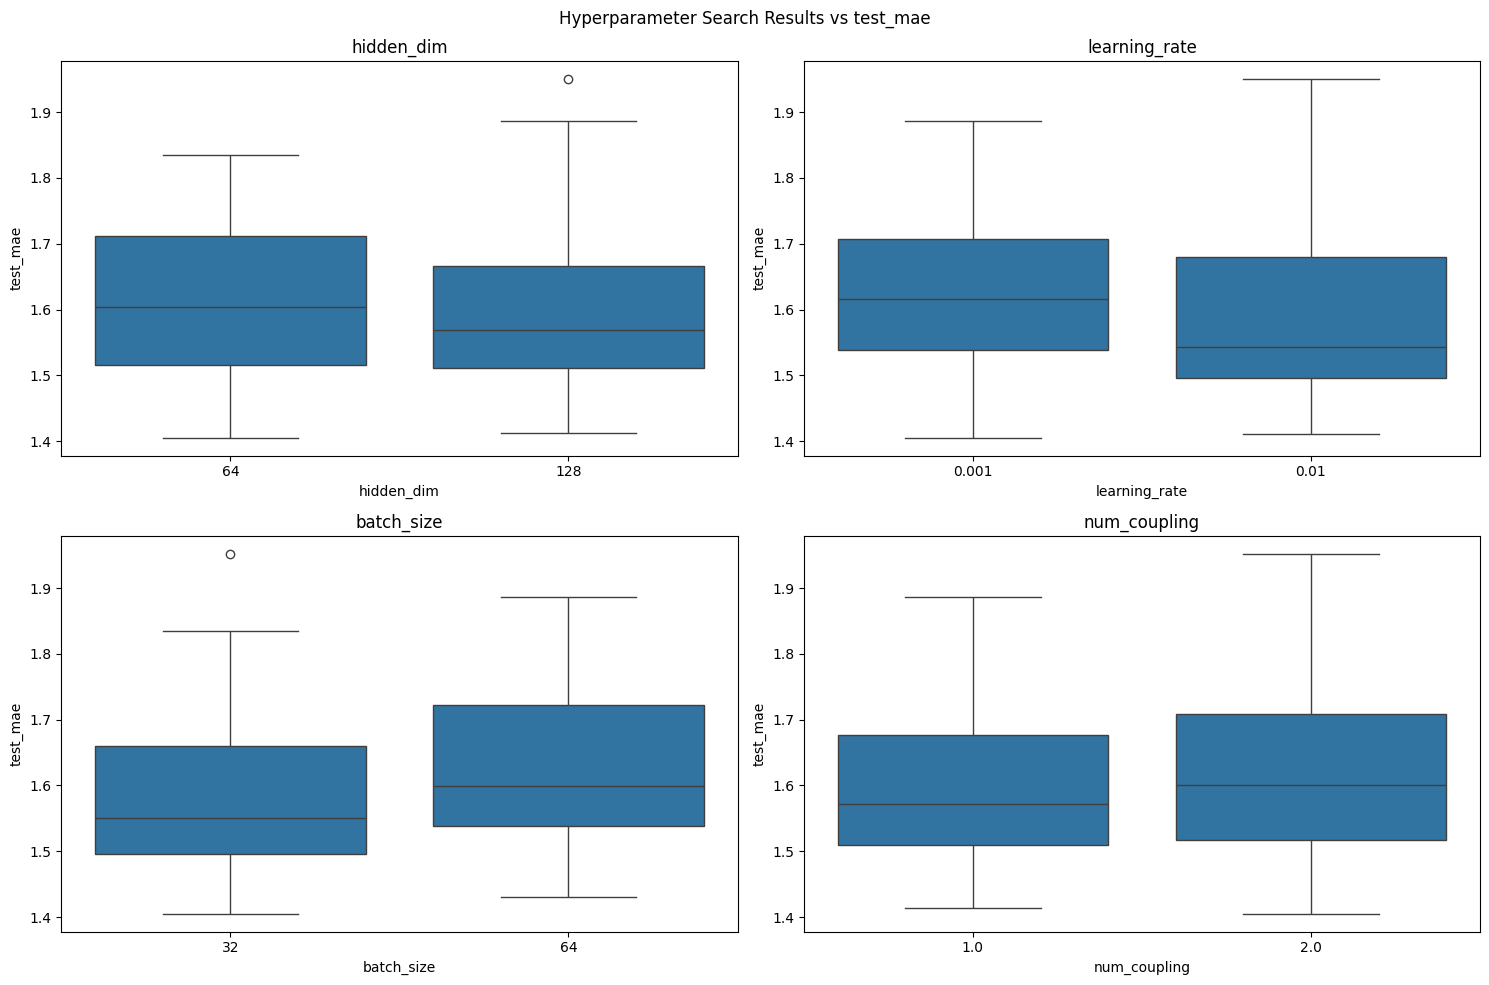

In [178]:
metric = "test_mae"

# Create subplots for each hyperparameter
fig, axes = plt.subplots(len(hypers) // 2 + len(hypers) % 2, 2, figsize=(15, 10))
axes = axes.flatten()
fig.suptitle(f"Hyperparameter Search Results vs {metric}")

for i, hyper in enumerate(hypers):
    if hyper in df_clean.columns:
        sns.boxplot(data=df_clean, x=hyper, y=metric, ax=axes[i])
    axes[i].set_title(hyper)

plt.tight_layout()
plt.show()

In [179]:
# Group by the hyperparameters and calculate mean and std for each metric
grouped_df = df_clean.groupby(hypers).agg(["mean", "std", "count"])

# Flatten the MultiIndex columns
grouped_df.columns = ["_".join(col).strip() for col in grouped_df.columns.values]

grouped_df.reset_index(inplace=True)

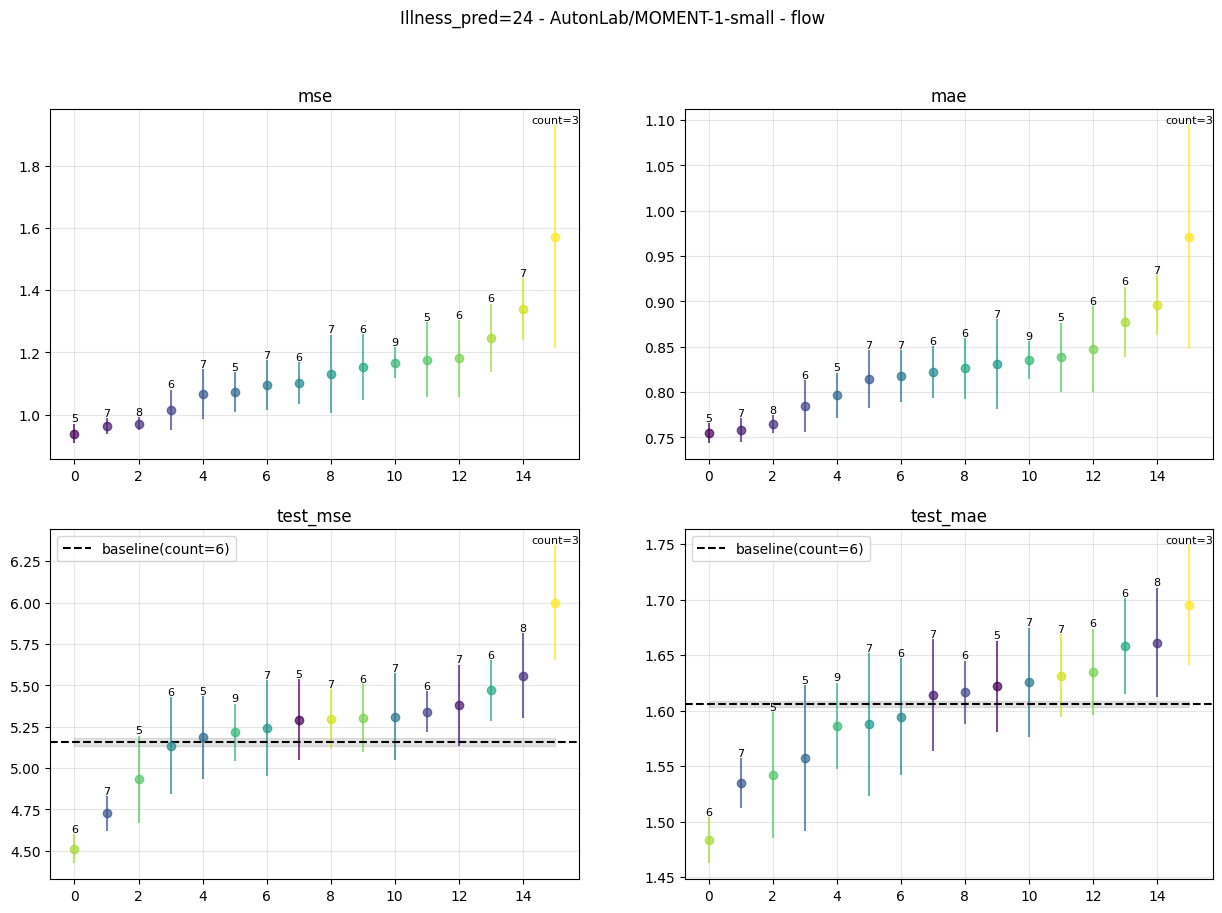

In [180]:
metrics = ["mse", "mae", "test_mse", "test_mae"]
fig, axes = plt.subplots(len(metrics) // 2, 2, figsize=(15, 10))
fig.suptitle(f"{dataset_name} - {model_name} - {adapter}")
axes = axes.flatten()

# Create a color map based on initial rankings for mse
num_configs = len(grouped_df)
colors = plt.cm.viridis(np.linspace(0, 1, num_configs))

# Get initial ranking order based on mse
initial_order = grouped_df.sort_values(by="mse_mean").index
color_dict = dict(zip(initial_order, colors))

for i, metric in enumerate(metrics):
    # Sort by the specified metric mean
    sorted_df = grouped_df.sort_values(by=f"{metric}_mean")

    # Plot points with error bars using consistent colors
    size = len(sorted_df)
    for idx, row in sorted_df.iterrows():
        axes[i].errorbar(
            x=sorted_df.index.get_loc(idx),
            y=row[f"{metric}_mean"],
            yerr=row[f"{metric}_std"] / np.sqrt(row[f"{metric}_count"]),
            fmt="o",
            color=color_dict[idx],
            alpha=0.7,
        )
        ct = int(row[f"{metric}_count"])
        axes[i].text(
            sorted_df.index.get_loc(idx),
            row[f"{metric}_mean"]
            + row[f"{metric}_std"] / np.sqrt(row[f"{metric}_count"]),
            f"count={ct}" if idx == size - 1 else str(ct),
            fontsize=8,
            ha="center",
            va="bottom",
        )

    # baseline
    if "test" in metric:
        values = df_baseline_clean.loc[df_baseline_clean["metric"] == metric[5:]][
            "value"
        ]
        baseline = values.mean()
        baseline_std = values.std()
        x_range = [0, len(sorted_df) - 1]
        axes[i].axhline(
            y=baseline,
            color="black",
            linestyle="--",
            label=f"baseline(count={len(values)})",
        )
        axes[i].fill_between(
            x_range,
            [baseline - baseline_std / np.sqrt(len(values))],
            [baseline + baseline_std / np.sqrt(len(values))],
            color="black",
            alpha=0.1,
        )
        axes[i].legend()

    axes[i].set_title(metric)
    axes[i].grid(True, alpha=0.3)
plt.show()